# Создание sub-mehanism

In [1]:
from timeit import default_timer
import cantera as ct
import numpy as np
import matplotlib.pyplot as plt

all_species = ct.Species.listFromFile('gri30.xml')
species = []

# Filter species
for S in all_species:
    comp = S.composition
    if 'C' in comp:
        # Exclude all hydrocarbon species
        continue
    if 'N' in comp:
        # Exclude all nitrogen compounds except for N2
        continue
    if 'Ar' in comp:
        # Exclude Argon
        continue

    species.append(S)

species_names = {S.name for S in species}
print('Species: {0}'.format(', '.join(S.name for S in species)))



Species: H2, H, O, O2, OH, H2O, HO2, H2O2


In [2]:
# Filter reactions, keeping only those that only involve the selected species
all_reactions = ct.Reaction.listFromFile('gri30.xml')
reactions = []
reactions_name = []

print('\nReactions:')
for R in all_reactions:
    if not all(reactant in species_names for reactant in R.reactants):
        continue

    if not all(product in species_names for product in R.products):
        continue
    
    if 'M' in R.reactant_string:
        continue
    
#     if R.equation in reactions_name:
#         continue
    reactions_name.append(R.equation)
    reactions.append(R)
    print(R.equation)
print('\n')




Reactions:
H2 + O <=> H + OH
HO2 + O <=> O2 + OH
H2O2 + O <=> HO2 + OH
H + 2 O2 <=> HO2 + O2
H + H2O + O2 <=> H2O + HO2
H + O2 <=> O + OH
2 H + H2 <=> 2 H2
2 H + H2O <=> H2 + H2O
H + HO2 <=> H2O + O
H + HO2 <=> H2 + O2
H + HO2 <=> 2 OH
H + H2O2 <=> H2 + HO2
H + H2O2 <=> H2O + OH
H2 + OH <=> H + H2O
2 OH <=> H2O + O
HO2 + OH <=> H2O + O2
H2O2 + OH <=> H2O + HO2
H2O2 + OH <=> H2O + HO2
2 HO2 <=> H2O2 + O2
2 HO2 <=> H2O2 + O2
HO2 + OH <=> H2O + O2




In [3]:
len(reactions)

21

# Create train set

In [4]:
T0 = 1300
P0 = 1.5*ct.one_atm
C = 'H2:2,O2:1'

In [5]:
dict_of_state = {}

In [6]:
for T in np.arange(T0,T0+200,5):
    gas_sub = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

    gas_sub.TPX = T, P0, C
    r = ct.IdealGasConstPressureReactor(gas_sub, energy ='off')

    sim = ct.ReactorNet([r])
    time = 0.0
    states = ct.SolutionArray(gas_sub, extra=['t'])

    print(T)
    for n in range(200):
        
        time += 1.e-7
        sim.advance(time)
        states.append(r.thermo.state, t=time*1e6)
    all_array = np.hstack([states.X, states.T.reshape(-1,1), states.P.reshape(-1,1),states.t.reshape(-1,1)])
    dict_of_state[T] = all_array



1300
1305
1310
1315
1320
1325
1330
1335
1340
1345
1350
1355
1360
1365
1370
1375
1380
1385
1390
1395
1400
1405
1410
1415
1420
1425
1430
1435
1440
1445
1450
1455
1460
1465
1470
1475
1480
1485
1490
1495


In [7]:
import pickle

In [8]:
with open('states.pkl', 'wb') as f:
     pickle.dump(dict_of_state, f)

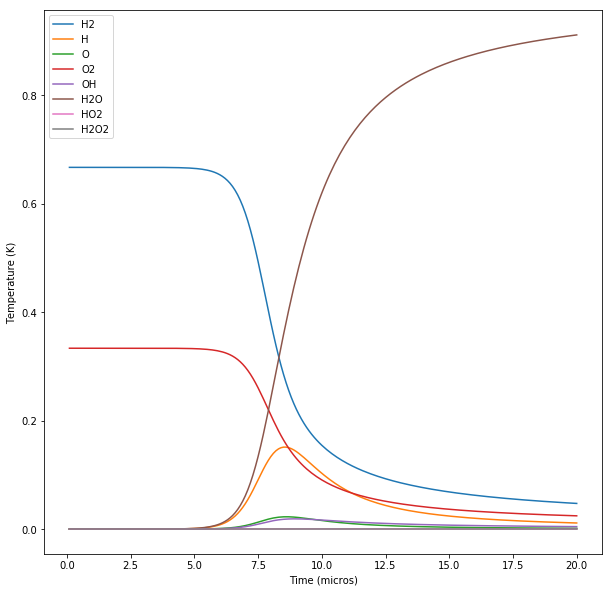

In [9]:
plt.figure(figsize = (10,10))
plt.plot(dict_of_state[1395][:,-1], dict_of_state[1300][:,:8])
plt.xlabel('Time (micros)')
plt.ylabel('Temperature (K)')
plt.legend(states.species_names)
plt.show()

# Create Model

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
import sys
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

%matplotlib inline

# import cv2
from sklearn.model_selection import train_test_split

from tqdm import tqdm_notebook #, tnrange
#from itertools import chain
from skimage.io import imread, imshow #, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model, save_model
from keras.layers import Input,Dropout,BatchNormalization,Activation,Add, Dense
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras import optimizers

import tensorflow as tf

from keras.preprocessing.image import array_to_img, img_to_array, load_img#,save_img


/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
# Build model
def build_model(input_layer, hidden_neurons):
    # 101 -> 50
    x = Dense(hidden_neurons, activation = 'sigmoid')(input_layer)
    x = Dense(hidden_neurons, activation = 'sigmoid')(x)
    x = Dense(hidden_neurons, activation = 'sigmoid')(x)
    
    output_layer = Dense(1, activation = 'sigmoid')(x)
    
    return output_layer

In [13]:
def loss_function(y_true, y_pred):
    mae = K.abs(y_pred - y_true)
    log =  K.log(K.clip(y_pred, K.epsilon(), None)/ K.clip(y_true, K.epsilon(), None))
    return K.mean(K.square(mae+log))

In [14]:
models = []
input_layer = Input((10,))
for i in range(8):
    output_layer = build_model(input_layer, 16)

    model1 = Model(input_layer, output_layer)

    c = optimizers.adam(lr = 0.01)
    #model1.compile(loss=loss_function, optimizer=c, metrics=[loss_function])
    models.append(model1)

In [15]:
all_output = concatenate([model.output for model in models])

In [16]:
big_model = Model(input_layer, all_output)

In [17]:
big_model.compile(loss=loss_function, optimizer=c, metrics=[loss_function])

# Load train

In [18]:
train = pickle.load(open('states.pkl', 'rb'))

In [19]:
matrix = np.vstack([train[keys][:,:10] for keys in train.keys()])

In [20]:
matrix.shape

(8000, 10)

In [21]:
Eps = 1e-16

In [22]:
train_matrix = matrix+Eps

In [23]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


In [24]:
train_matrix = scaler.fit_transform(train_matrix)

In [25]:
test_matrix = np.roll(matrix, 1, axis=0)

In [30]:
train_matrix

array([[ 1.70206279, -0.87256894, -0.83218709, ..., -2.0755985 ,
        -0.90961097,  0.        ],
       [ 1.70206264, -0.87256836, -0.8321867 , ..., -2.07520325,
        -0.90961097,  0.        ],
       [ 1.70206245, -0.87256765, -0.83218616, ..., -2.07454307,
        -0.90961097,  0.        ],
       ...,
       [-0.7699469 , -0.61666803, -0.59127088, ...,  0.04753315,
         1.25612944,  1.01137881],
       [-0.77069358, -0.61893889, -0.59353714, ...,  0.04731807,
         1.25612944,  1.01137881],
       [-0.77143256, -0.62117488, -0.59576756, ...,  0.04709627,
         1.25612944,  1.01137881]])

In [31]:
test_matrix

array([[4.60336188e-02, 1.32562666e-02, 2.20599568e-03, ...,
        4.17314296e-07, 1.47000000e+03, 1.51987500e+05],
       [6.66666638e-01, 2.65398006e-08, 1.60592761e-09, ...,
        2.58546446e-11, 1.34500000e+03, 1.51987500e+05],
       [6.66666601e-01, 5.68112928e-08, 5.21451743e-09, ...,
        1.03553623e-10, 1.34500000e+03, 1.51987500e+05],
       ...,
       [4.65957049e-02, 1.36155396e-02, 2.26944159e-03, ...,
        4.17441097e-07, 1.47000000e+03, 1.51987500e+05],
       [4.64063889e-02, 1.34939165e-02, 2.24795350e-03, ...,
        4.17400179e-07, 1.47000000e+03, 1.51987500e+05],
       [4.62190372e-02, 1.33741722e-02, 2.22680737e-03, ...,
        4.17357899e-07, 1.47000000e+03, 1.51987500e+05]])

In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_matrix[:-1], test_matrix[1:,:8], test_size=0.1, random_state=42)

In [33]:
from keras.callbacks import *

class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or 
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each 
        cycle iteration.
    For more detail, please see paper.
    
    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```    
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore 
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on 
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())

In [ ]:
#early_stopping = EarlyStopping(monitor='my_iou_metric', mode = 'max',patience=10, verbose=1)
model_path = os.path.join("model", '123' + '-epoch-{epoch:03d}' + '-val_loss_function-{val_loss_function:.5f}' + '.hdf5')
model_checkpoint = ModelCheckpoint(model_path,monitor='val_loss_function' , save_best_only=True, verbose=0)
reduce_lr = ReduceLROnPlateau(monitor='val_my_iou_metric', mode = 'max',factor=0.5, patience=10, min_lr=0.0001, verbose=1)
clr = CyclicLR(base_lr=0.001, max_lr=0.01, step_size=1000) # 1/2 cycle per nb_epoch = steps_per_epoch * nb_epoch



history = big_model.fit(x = X_train, y = y_train,
                    callbacks=[ model_checkpoint,clr], 
                    verbose=0,
                    validation_data= (X_test,y_test),
                    batch_size = 512,
                    epochs = 100000, initial_epoch = 0)

In [35]:
1

1

In [36]:
from keras.models import load_model

model_folder = 'model/123-epoch-11009-val_loss_function-0.00019.hdf5'

In [37]:
model1 = load_model(model_folder, custom_objects={'loss_function': loss_function})

In [38]:
model1.evaluate(X_test, y_test)

800/800 [==============================] - 0s 182us/step


[0.0001878851358560496, 0.0001878851358560496]

# Evaluate

# true

In [39]:
gas_sub = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

gas_sub.TPX = 1372, P0, C
r = ct.IdealGasConstPressureReactor(gas_sub, energy ='off')

sim = ct.ReactorNet([r])
time = 0.0
states = ct.SolutionArray(gas_sub, extra=['t'])

for n in range(1000):

    time += 1.e-7
    sim.advance(time)
    states.append(r.thermo.state, t=time*1e6)



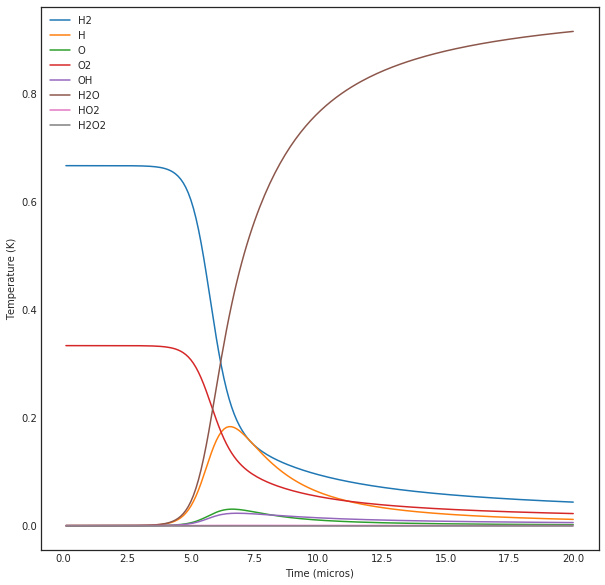

In [40]:
plt.figure(figsize = (10,10))
plt.plot(states.t[:200], states.X[:200])
plt.xlabel('Time (micros)')
plt.ylabel('Temperature (K)')
plt.legend(states.species_names)
plt.show()

# predict

In [41]:
gas_sub = ct.Solution(thermo='IdealGas', kinetics='GasKinetics',
                       species=species, reactions=reactions)

gas_sub.TPX = 1490, P0, C
r = ct.IdealGasConstPressureReactor(gas_sub, energy ='off')

sim = ct.ReactorNet([r])
time = 0.0
#states = ct.SolutionArray(gas_sub, extra=['t'])


In [42]:
r.thermo.X

array([0.66666667, 0.        , 0.        , 0.33333333, 0.        ,
       0.        , 0.        , 0.        ])

In [43]:
a = np.vstack([r.thermo.X.reshape(-1,1), np.array(r.thermo.T).reshape(-1,1), np.array(r.thermo.P).reshape(-1,1)]).T

In [44]:
a

array([[6.66666667e-01, 0.00000000e+00, 0.00000000e+00, 3.33333333e-01,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.49000000e+03, 1.51987500e+05]])

In [45]:
np.array(r.thermo.T).reshape(-1,1).shape

(1, 1)

In [ ]:
norm_input = scaler.transform(a)

In [ ]:
norm_input

In [222]:
b = model1.predict(norm_input)

In [223]:
b

array([[6.6614956e-01, 1.2205307e-07, 4.7630490e-08, 3.3331588e-01,
        1.9193468e-08, 2.9579917e-08, 2.0166736e-07, 2.6184470e-08]],
      dtype=float32)

In [224]:
%%time
all_pred = [a]
for i in range(200):
    norm_input = scaler.transform(a)
    
    b = model1.predict(norm_input)
    a = np.hstack([b, np.array(r.thermo.T).reshape(-1,1), np.array(r.thermo.P).reshape(-1,1)])
    all_pred.append(a)
    

CPU times: user 268 ms, sys: 24 ms, total: 292 ms
Wall time: 173 ms


In [225]:
all_pred =np.vstack(all_pred)

In [226]:
all_pred

array([[6.66666667e-01, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.49000000e+03, 1.51987500e+05],
       [6.66149557e-01, 1.22053066e-07, 4.76304898e-08, ...,
        2.61844697e-08, 1.49000000e+03, 1.51987500e+05],
       [6.66163623e-01, 4.56079943e-06, 8.37032246e-07, ...,
        3.72876805e-08, 1.49000000e+03, 1.51987500e+05],
       ...,
       [6.66022539e-01, 1.86111829e-05, 2.31580702e-06, ...,
        5.23636636e-08, 1.49000000e+03, 1.51987500e+05],
       [6.66022539e-01, 1.86111829e-05, 2.31580702e-06, ...,
        5.23636636e-08, 1.49000000e+03, 1.51987500e+05],
       [6.66022539e-01, 1.86111829e-05, 2.31580702e-06, ...,
        5.23636636e-08, 1.49000000e+03, 1.51987500e+05]])

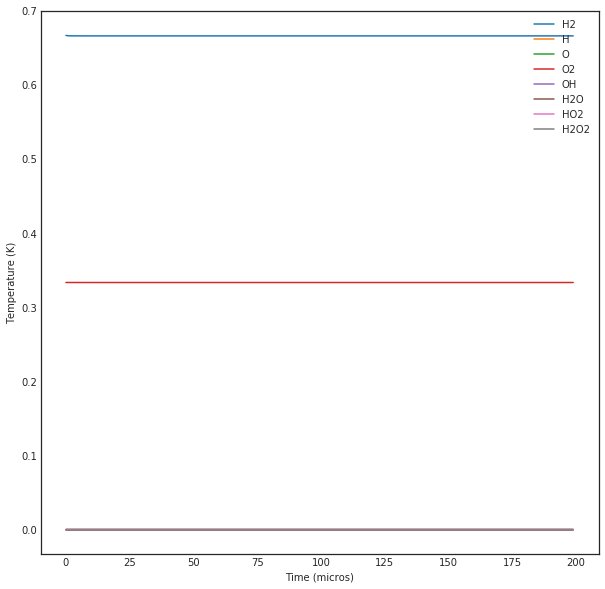

In [227]:
plt.figure(figsize = (10,10))
plt.plot(all_pred[:200,:8])
plt.xlabel('Time (micros)')
plt.ylabel('Temperature (K)')
plt.legend(states.species_names)
plt.show()